# Classification of Nigerian Traditional Attire

This project classifies images of Nigerian ethnic groups using transfer learning with convolutional neural networks. We experiment with ResNet18, ResNet34, and EfficientNet to compare performance.


### Downloading Data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/path_to/data_split'


Mounted at /content/drive


### Unzipping the file

In [ ]:
!unzip -q '/content/drive/MyDrive/nigerian_attire.zip' -d /content/

### Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


### Data Preparation

In [2]:
import os
import shutil
import random

def split_dataset(source_dir, dest_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."

    # Create destination folders
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dest_dir, split)
        os.makedirs(split_path, exist_ok=True)

    # Process each class folder
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        images = os.listdir(cls_path)
        random.shuffle(images)

        train_cutoff = int(train_ratio * len(images))
        val_cutoff = int((train_ratio + val_ratio) * len(images))

        split_sets = {
            'train': images[:train_cutoff],
            'val': images[train_cutoff:val_cutoff],
            'test': images[val_cutoff:]
        }

        for split, split_images in split_sets.items():
            split_dir = os.path.join(dest_dir, split, cls)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                src = os.path.join(cls_path, img)
                dst = os.path.join(split_dir, img)
                shutil.copy2(src, dst)

    print("✅ Dataset split complete.")

# Usage
split_dataset('nigerian_attire', 'data_split', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)


✅ Dataset split complete.


### Data Transforms and Loaders

In [3]:
import os
import random
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

# ✅ Set seed for everything
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# ✅ Define generator for reproducible DataLoader shuffling
g = torch.Generator()
g.manual_seed(42)

# ✅ Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Has randomness
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# ✅ Load datasets
data_dir = 'data_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

# ✅ Use generator and set num_workers=0 for determinism
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True,
                             num_workers=0, worker_init_fn=lambda _: set_seed(42),
                             generator=g)
               for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Model Definition (Pretrained ResNet34)

In [4]:
from torchvision.models import resnet34
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)


/home/naziruai/miniconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/naziruai/miniconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/naziruai/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

### Loss, Optimizer, and Class Weights

In [ ]:
# Optional: Use class weights to handle imbalance
class_counts = torch.tensor([len([label for _, label in image_datasets['train'] if label == i]) for i in range(len(class_names))])
class_weights = 1. / class_counts.float()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


### Training Loop with Early Stopping

In [ ]:
num_epochs = 10
patience = 5
best_accuracy = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    # else:
    #     epochs_no_improve += 1
    #     if epochs_no_improve == patience:
    #         print("Early stopping!")
    #         break

    lr_scheduler.step()


Epoch 1/10, Loss: 38.5000, Val Accuracy: 24.85%
Epoch 2/10, Loss: 29.5152, Val Accuracy: 52.73%
Epoch 3/10, Loss: 26.1802, Val Accuracy: 53.94%
Epoch 4/10, Loss: 21.5091, Val Accuracy: 64.85%
Epoch 5/10, Loss: 18.8728, Val Accuracy: 72.12%
Epoch 6/10, Loss: 13.9455, Val Accuracy: 78.79%
Epoch 7/10, Loss: 10.6747, Val Accuracy: 85.45%
Epoch 8/10, Loss: 7.5829, Val Accuracy: 88.48%
Epoch 9/10, Loss: 7.5027, Val Accuracy: 89.09%
Epoch 10/10, Loss: 5.2106, Val Accuracy: 87.88%


### Test the Model

In [1]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct, total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


NameError: name 'model' is not defined

### Confusion Matrix and Classification Report

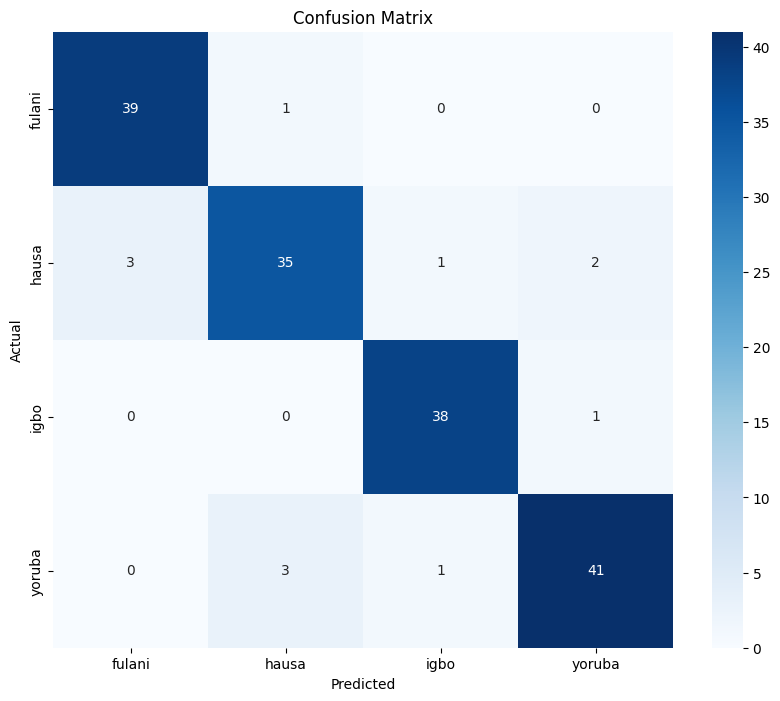

              precision    recall  f1-score   support

      fulani       0.93      0.97      0.95        40
       hausa       0.90      0.85      0.88        41
        igbo       0.95      0.97      0.96        39
      yoruba       0.93      0.91      0.92        45

    accuracy                           0.93       165
   macro avg       0.93      0.93      0.93       165
weighted avg       0.93      0.93      0.93       165



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))


### Saving the Model

In [ ]:
import torch
torch.save(model, 'resnet34_nigerian_ethnic_classifier.pth')


NameError: name 'model' is not defined

In [ ]:
# import torchvision.models as models

# # Recreate the same model architecture
# model = models.resnet34(weights=None)
# num_ftrs = model.fc.in_features
# model.fc = torch.nn.Linear(num_ftrs, 4)  # Assuming 4 classes

# # Load weights
# model.load_state_dict(torch.load("resnet34_nigerian_ethnic_classifier.pth"))
# model.eval()
